In [56]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import warnings; warnings.simplefilter('ignore')

In [57]:
def convert_to_float(data_fm, features):
    for column in features:
        data_fm[column].fillna(method='bfill', inplace=True)
        data_fm[column].fillna(method='ffill', inplace=True)
        data_fm[column].fillna(method='backfill', inplace=True)
        
        if data_fm[column].dtype == 'object':
            try:
                data_fm[column] = data_fm[column].astype(np.float64)
            except:
                data_fm[column] = data_fm[column].str.replace(',', '').astype(np.float64)
                continue
            
        data_fm.fillna(method='pad', inplace=True)
        df.fillna(0, inplace=True)

    return data_fm

def encode_label(edited_df):
    for df in [edited_df]:

        X = df.select_dtypes(include=['object'])
        print("Columns size = ", (X.shape[1]))
        if (X.shape[1]) >= 1 and "fund_id" not in X.columns:
            le = preprocessing.LabelEncoder()
            X_2 = X.astype(str).apply(le.fit_transform)

            for col in X_2.columns:
                df[col] = X_2[col]

        df.fillna(method='pad', inplace=True)
        df.fillna(0, inplace=True)
        
    return df

def cleanse_data(data_to_cleanse, label_to_float):
    data_to_cleanse = convert_to_float(data_to_cleanse, label_to_float)
    data_to_cleanse = encode_label(data_to_cleanse)
    
    print("cleanse_data ", data_to_cleanse.info())
    #print(data_to_cleanse.describe(include='all'))
    
    return data_to_cleanse

In [58]:
def encode_label_without_dropna(edited_df):
    for df in [edited_df]:
        X = df.select_dtypes(include=['object'])
        print("Columns size = ", (X.shape[1]))
        if (X.shape[1]) >= 1:
            le = preprocessing.LabelEncoder()
            X_2 = X.astype(str).apply(le.fit_transform)

            for col in X_2.columns:
                df[col] = X_2[col]

        df.fillna(method='pad', inplace=True)
        df.fillna(0, inplace=True)
        
    return df

def cleanse_data_without_dropna(data_to_cleanse, label_to_float):
    data_to_cleanse = convert_to_float(data_to_cleanse, label_to_float)
    data_to_cleanse = encode_label_without_dropna(data_to_cleanse)

    return data_to_cleanse

In [172]:
min_max_correlation_cutoff_point = 0.005

def drop_unused_columns(data, columns):
    for column in columns:
        if column in data.columns:
            data.drop(columns=[column], inplace=True)
            
    return data

def join_file(data_1, data_2):
    joint_file = []
    if "tag" in data_1.columns:
        data_2 = drop_unused_columns(data_2, ['fund_id'])
        joint_file = data_1.merge(data_2, how='left', on='tag')
    else:
        data_2 = drop_unused_columns(data_2, ['tag'])
        joint_file = data_1.merge(data_2, how='left', on='fund_id')
        
    return joint_file

def drop_low_correlation_columns(x):
    if x.values[0] < min_max_correlation_cutoff_point and x.values[0] > -(min_max_correlation_cutoff_point):
        if x.name == "tag" or x.name == 'fund_id':
            join_1.drop(columns=[x.name], inplace = True) 

def print_correlation(data):
    join_1 = []
    tag_rating = pd.read_csv('tag_rating.csv')
    tag_rating = encode_label(tag_rating)
    
    if 'greatstone_rating' in data.columns:
        data.drop(columns='greatstone_rating', inplace=True)
    
    if 'fund_id' in data.columns:
        join_1 = drop_unused_columns(data, ['tag'])
        join_1 = tag_rating.merge(data, how='left', on='fund_id')
    else:
        join_1 = drop_unused_columns(data, ['fund_id'])
        join_1 = tag_rating.merge(data, how='left', on='tag')
    
    print("1.1", [column for column in join_1.columns])
    list_of_correlation = join_1.corr(method='pearson')[['greatstone_rating']].sort_values(by=['greatstone_rating'], ascending=False)
    join_1 = drop_unused_columns(join_1, ['greatstone_rating'])
    
    print("top list of correlation ", list_of_correlation[:20])
    print("bottom list of correlation ", list_of_correlation[-5:])
    #list_of_correlation.apply(lambda x: print("start", x.values[0], x.name), axis=1)
    
    list_of_correlation.apply(lambda x: join_1.drop(columns=[x.name], inplace = True) if ((x.values[0] < min_max_correlation_cutoff_point and x.values[0] > -(min_max_correlation_cutoff_point))) else 0, axis=1)
    #list_of_correlation.apply(drop_low_correlation_columns(join_1), axis=1)
    #list_of_correlation.apply(lambda x: x if list_of_correlation[x.name] > 0.01 else 0, axis=1)
    #list_of_correlation.apply(lambda x: join_1.drop(columns=[x.name]) if ), axis=1)
    
    join_1['fund_id'] = tag_rating['fund_id']
    join_1['tag'] = tag_rating['tag']
    
    print("join_1 ", join_1.info())
    
    return join_1
    

# Cleanse Data

## fund_config

In [173]:
fund_config = pd.read_csv('fund_config.csv')
fund_config.info()

fund_config = encode_label(fund_config)
fund_config.describe()
fund_config = fund_config.drop(columns=['fund_name', 'parent_company'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
category          25000 non-null object
parent_company    25000 non-null object
fund_id           25000 non-null object
fund_name         25000 non-null object
dtypes: object(4)
memory usage: 781.3+ KB
Columns size =  4


In [174]:
fund_config.describe()
fund_config.to_csv("file_1.csv")

# fund_ratios

In [175]:
fund_ratios = pd.read_csv('fund_ratios.csv')

fund_ratios = cleanse_data(fund_ratios, ['ps_ratio', 'mmc', 'pc_ratio'])

Columns size =  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 8 columns):
fund_id                          25000 non-null object
tag                              25000 non-null int64
fund_ratio_net_annual_expense    25000 non-null float64
pb_ratio                         25000 non-null float64
ps_ratio                         25000 non-null float64
mmc                              25000 non-null float64
pc_ratio                         25000 non-null float64
pe_ratio                         25000 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ MB
cleanse_data  None


In [176]:
fund_ratios = print_correlation(fund_ratios)
fund_ratios.to_csv("file_2.csv")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', 'fund_ratio_net_annual_expense', 'pb_ratio', 'ps_ratio', 'mmc', 'pc_ratio', 'pe_ratio']
top list of correlation                                 greatstone_rating
greatstone_rating                       1.000000
mmc                                     0.057649
pb_ratio                                0.037908
pc_ratio                                0.012864
tag                                     0.001416
Unnamed: 0                             -0.002920
ps_ratio                               -0.003275
fund_ratio_net_annual_expense          -0.195454
bottom list of correlation                                 greatstone_rating
pc_ratio                                0.012864
tag                                     0.001416
Unnamed: 0                             -0.002920
ps_ratio                               -0.003275
fund_ratio_net_annual_expense          -0.195454
<class 'pandas.core.frame.DataFrame'>
Int64Index

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020ADF6FA898>,
      dtype=object)

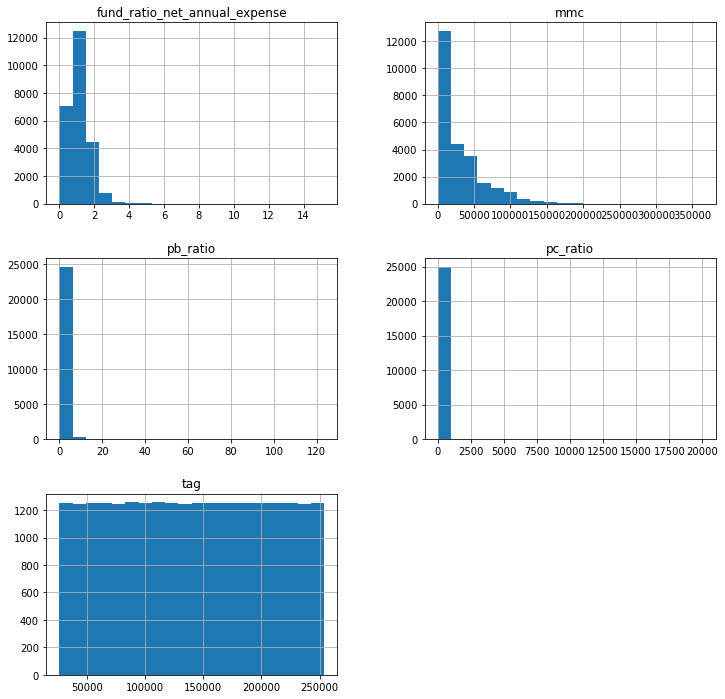

In [177]:
fund_ratios.hist(stacked=False, bins=20, figsize=(12, 12))

In [178]:
join_1 = join_file(fund_config, fund_ratios)
join_1.head()
join_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 7 columns):
category                         25000 non-null object
fund_id                          25000 non-null object
fund_ratio_net_annual_expense    25000 non-null float64
pb_ratio                         25000 non-null float64
mmc                              25000 non-null float64
pc_ratio                         25000 non-null float64
pe_ratio                         25000 non-null object
dtypes: float64(4), object(3)
memory usage: 1.5+ MB


## bond_ratings

In [179]:
bond_ratings = pd.read_csv('bond_ratings.csv')
bond_ratings.info()
bond_ratings = cleanse_data(bond_ratings, [])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
bb_rating              24886 non-null float64
us_govt_bond_rating    24886 non-null float64
below_b_rating         24886 non-null float64
others_rating          24886 non-null float64
maturity_bond          8093 non-null float64
b_rating               24886 non-null float64
tag                    25000 non-null int64
a_rating               24886 non-null float64
aaa_rating             24886 non-null float64
aa_rating              24886 non-null float64
bbb_rating             24886 non-null float64
duration_bond          9874 non-null float64
dtypes: float64(11), int64(1)
memory usage: 2.3 MB
Columns size =  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
bb_rating              25000 non-null float64
us_govt_bond_rating    25000 non-null float64
below_b_rating         25000 non-null float64
others_rating          2500

In [180]:
bond_ratings = print_correlation(bond_ratings)
bond_ratings.to_csv("file_3.csv")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', 'bb_rating', 'us_govt_bond_rating', 'below_b_rating', 'others_rating', 'maturity_bond', 'b_rating', 'a_rating', 'aaa_rating', 'aa_rating', 'bbb_rating', 'duration_bond']
top list of correlation                       greatstone_rating
greatstone_rating             1.000000
below_b_rating                0.047433
a_rating                      0.045070
bbb_rating                    0.044768
aa_rating                     0.036690
maturity_bond                 0.035889
b_rating                      0.035764
bb_rating                     0.034758
others_rating                 0.025994
aaa_rating                    0.021471
duration_bond                 0.016162
tag                           0.001416
Unnamed: 0                   -0.002920
us_govt_bond_rating                NaN
bottom list of correlation                       greatstone_rating
aaa_rating                    0.021471
duration_bond                 0.016162

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020ADEDE1940>,
      dtype=object)

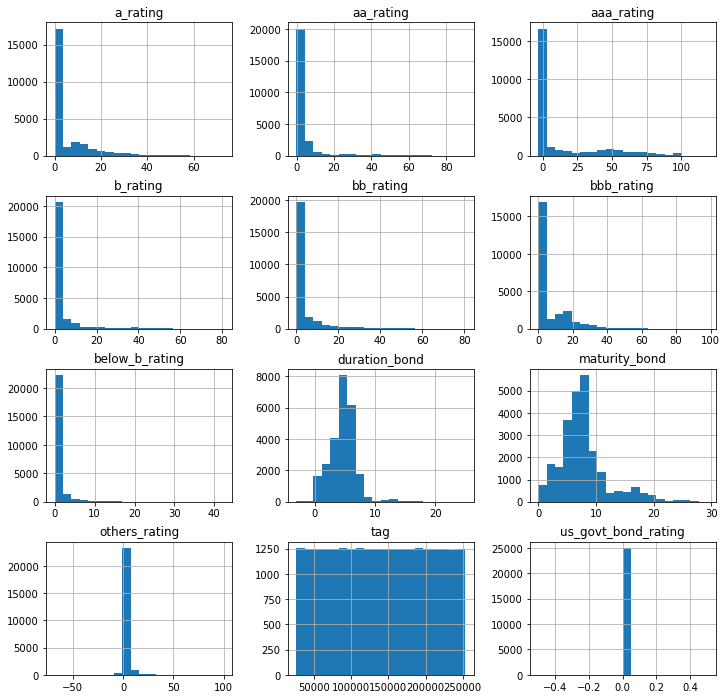

In [181]:
bond_ratings.hist(stacked=False, bins=20, figsize=(12, 12))

In [182]:
join_2 = join_file(join_1, bond_ratings)
join_2.head()
join_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 18 columns):
category                         25000 non-null object
fund_id                          25000 non-null object
fund_ratio_net_annual_expense    25000 non-null float64
pb_ratio                         25000 non-null float64
mmc                              25000 non-null float64
pc_ratio                         25000 non-null float64
pe_ratio                         25000 non-null object
bb_rating                        25000 non-null float64
us_govt_bond_rating              25000 non-null float64
below_b_rating                   25000 non-null float64
others_rating                    25000 non-null float64
maturity_bond                    25000 non-null float64
b_rating                         25000 non-null float64
a_rating                         25000 non-null float64
aaa_rating                       25000 non-null float64
aa_rating                        25000 non-null float6

## fund_allocations

In [183]:
fund_allocations = pd.read_csv('fund_allocations.csv')
fund_allocations['tag'] = fund_allocations['id']
fund_allocations = cleanse_data(fund_allocations, [])

Columns size =  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 13 columns):
portfolio_communication_allocation        25000 non-null float64
portfolio_financial_services              25000 non-null float64
portfolio_industrials_allocation          25000 non-null float64
portfolio_tech_allocation                 25000 non-null float64
portfolio_materials_basic_allocation      25000 non-null float64
portfolio_energy_allocation               25000 non-null float64
portfolio_consumer_defence_allocation     25000 non-null float64
portfolio_healthcare_allocation           25000 non-null float64
portfolio_property_allocation             25000 non-null float64
id                                        25000 non-null int64
portfolio_utils_allocation                25000 non-null float64
portfolio_cyclical_consumer_allocation    25000 non-null float64
tag                                       25000 non-null int64
dtypes: float64(11), int64(2)
me

In [184]:
fund_allocations = print_correlation(fund_allocations)
fund_allocations.to_csv("file_4.csv")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', 'portfolio_communication_allocation', 'portfolio_financial_services', 'portfolio_industrials_allocation', 'portfolio_tech_allocation', 'portfolio_materials_basic_allocation', 'portfolio_energy_allocation', 'portfolio_consumer_defence_allocation', 'portfolio_healthcare_allocation', 'portfolio_property_allocation', 'id', 'portfolio_utils_allocation', 'portfolio_cyclical_consumer_allocation']
top list of correlation                                          greatstone_rating
greatstone_rating                                1.000000
portfolio_tech_allocation                        0.053973
portfolio_cyclical_consumer_allocation           0.025370
portfolio_healthcare_allocation                  0.021375
portfolio_financial_services                     0.008069
portfolio_utils_allocation                       0.006027
portfolio_materials_basic_allocation             0.002122
portfolio_energy_allocation               

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020AD506A710>,
      dtype=object)

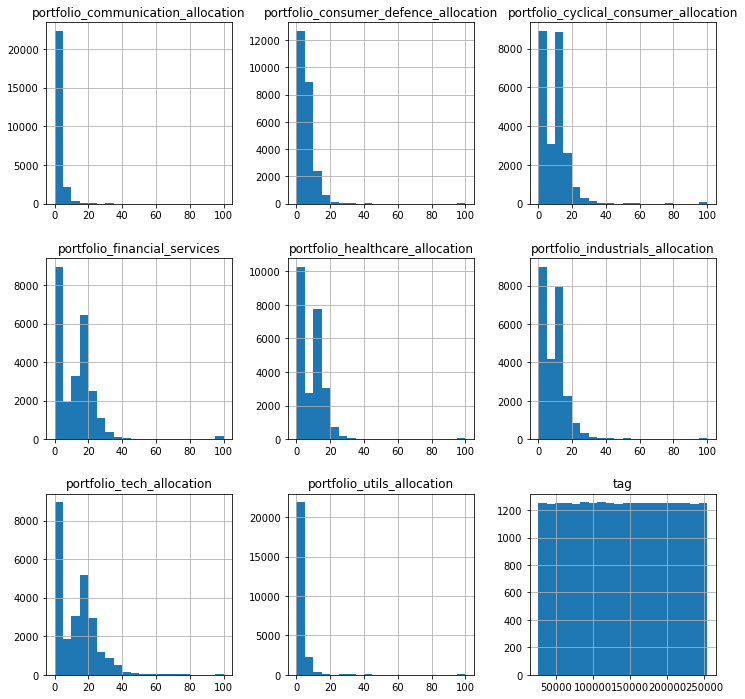

In [185]:
fund_allocations.hist(stacked=False, bins=20, figsize=(12, 12))

In [186]:
join_3 = join_file(join_2, fund_allocations)
join_3.head()
join_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 26 columns):
category                                  25000 non-null object
fund_id                                   25000 non-null object
fund_ratio_net_annual_expense             25000 non-null float64
pb_ratio                                  25000 non-null float64
mmc                                       25000 non-null float64
pc_ratio                                  25000 non-null float64
pe_ratio                                  25000 non-null object
bb_rating                                 25000 non-null float64
us_govt_bond_rating                       25000 non-null float64
below_b_rating                            25000 non-null float64
others_rating                             25000 non-null float64
maturity_bond                             25000 non-null float64
b_rating                                  25000 non-null float64
a_rating                                  25000 n

## fund_specs

In [187]:
fund_specs = pd.read_csv('fund_specs.csv')
fund_specs = cleanse_data(fund_specs, [])

Columns size =  4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
investment_class     25000 non-null int32
currency             25000 non-null int32
total_assets         25000 non-null float64
yield                25000 non-null float64
greatstone_rating    25000 non-null float64
inception_date       25000 non-null int32
tag                  25000 non-null int64
fund_size            25000 non-null int32
return_ytd           25000 non-null float64
dtypes: float64(4), int32(4), int64(1)
memory usage: 1.3 MB
cleanse_data  None


In [188]:
fund_specs = print_correlation(fund_specs)
fund_specs.to_csv("file_5.csv")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', 'investment_class', 'currency', 'total_assets', 'yield', 'inception_date', 'fund_size', 'return_ytd']
top list of correlation                     greatstone_rating
greatstone_rating           1.000000
total_assets                0.093287
return_ytd                  0.087925
yield                       0.066300
tag                         0.001416
Unnamed: 0                 -0.002920
investment_class           -0.020049
fund_size                  -0.024523
inception_date             -0.128087
currency                         NaN
bottom list of correlation                    greatstone_rating
Unnamed: 0                -0.002920
investment_class          -0.020049
fund_size                 -0.024523
inception_date            -0.128087
currency                        NaN
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 9 columns):
fund_id             25000 non-null obj

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020AE5FCDB70>,
      dtype=object)

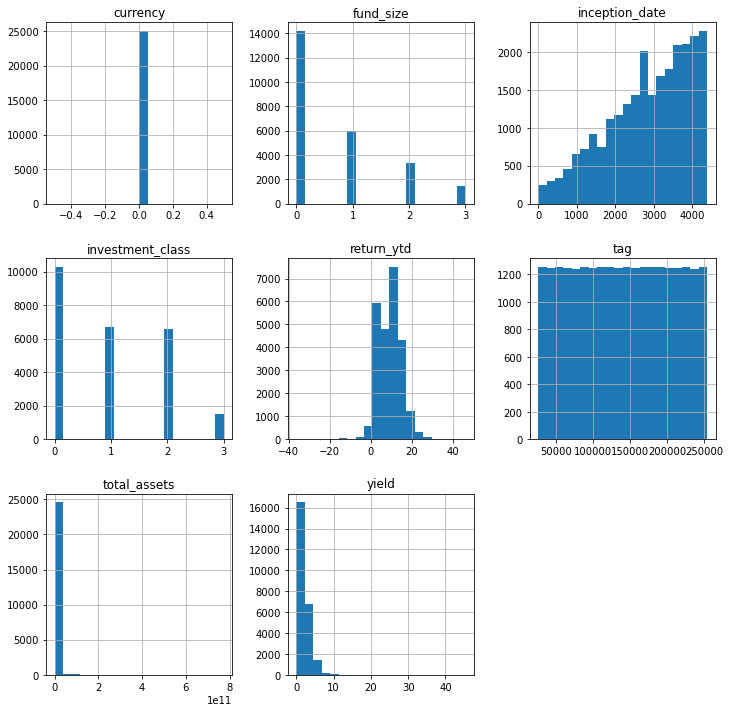

In [189]:
fund_specs.hist(stacked=False, bins=20, figsize=(12, 12))

In [190]:
join_4 = join_file(join_3, fund_specs)
join_4.head()
join_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 33 columns):
category                                  25000 non-null object
fund_id                                   25000 non-null object
fund_ratio_net_annual_expense             25000 non-null float64
pb_ratio                                  25000 non-null float64
mmc                                       25000 non-null float64
pc_ratio                                  25000 non-null float64
pe_ratio                                  25000 non-null object
bb_rating                                 25000 non-null float64
us_govt_bond_rating                       25000 non-null float64
below_b_rating                            25000 non-null float64
others_rating                             25000 non-null float64
maturity_bond                             25000 non-null float64
b_rating                                  25000 non-null float64
a_rating                                  25000 n

## other_specs

In [191]:
other_specs = pd.read_csv('other_specs.csv')
other_specs = cleanse_data(other_specs, [])

Columns size =  4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 43 columns):
2014_category_return                 25000 non-null float64
2012_return_category                 25000 non-null float64
years_up                             25000 non-null float64
2018_return_category                 25000 non-null float64
tag                                  25000 non-null int64
category_return_1year                25000 non-null float64
cash_percent_of_portfolio            25000 non-null float64
pc_ratio                             25000 non-null int32
2011_return_category                 25000 non-null float64
ytd_return_fund                      25000 non-null float64
years_down                           25000 non-null float64
2014_return_fund                     25000 non-null float64
category_return_1month               25000 non-null float64
2013_return_fund                     25000 non-null float64
fund_return_3months                  

In [192]:
other_specs = print_correlation(other_specs)
other_specs.to_csv("file_6.csv")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', '2014_category_return', '2012_return_category', 'years_up', '2018_return_category', 'category_return_1year', 'cash_percent_of_portfolio', 'pc_ratio', '2011_return_category', 'ytd_return_fund', 'years_down', '2014_return_fund', 'category_return_1month', '2013_return_fund', 'fund_return_3months', 'ytd_return_category', 'pb_ratio', '2017_category_return', '1_year_return_fund', 'pe_ratio', '2015_return_fund', 'portfolio_convertable', '3_months_return_category', 'portfolio_others', '2016_return_fund', 'mmc', 'stock_percent_of_portfolio', '2016_return_category', 'ps_ratio', '2011_return_fund', '2010_return_fund', 'fund_return_3years', '2012_fund_return', '2018_return_fund', '2017_return_fund', 'category_ratio_net_annual_expense', 'category_return_2015', '1_month_fund_return', 'bond_percentage_of_porfolio', 'portfolio_preferred', '2010_return_category', '2013_category_return']
top list of correlation                  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020AC73F7390>,
      dtype=object)

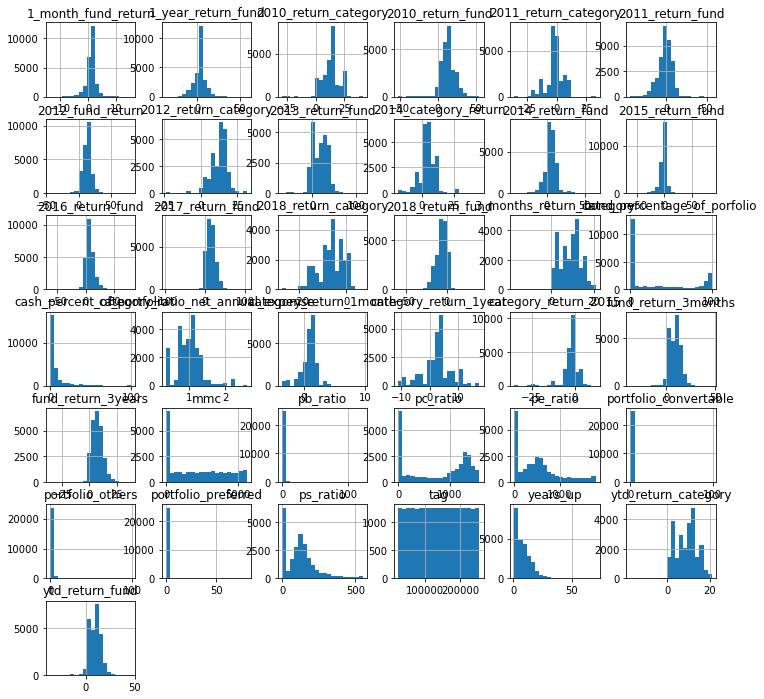

In [193]:
other_specs.hist(stacked=False, bins=20, figsize=(12, 12))

In [194]:
join_5 = join_file(join_4, other_specs)
join_5.head()
join_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 69 columns):
category                                  25000 non-null object
fund_id                                   25000 non-null object
fund_ratio_net_annual_expense             25000 non-null float64
pb_ratio_x                                25000 non-null float64
mmc_x                                     25000 non-null float64
pc_ratio_x                                25000 non-null float64
pe_ratio_x                                25000 non-null object
bb_rating                                 25000 non-null float64
us_govt_bond_rating                       25000 non-null float64
below_b_rating                            25000 non-null float64
others_rating                             25000 non-null float64
maturity_bond                             25000 non-null float64
b_rating                                  25000 non-null float64
a_rating                                  25000 n

## return_3year

In [195]:
return_3year = pd.read_csv('return_3year.csv')
return_3year = cleanse_data(return_3year, [])
return_3year = print_correlation(return_3year)
return_3year.to_csv("file_7.csv")
join_6 = join_file(join_5, return_3year)

Columns size =  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
tag                                    25000 non-null int64
3yrs_treynor_ratio_fund                25000 non-null int32
3_years_alpha_fund                     25000 non-null float64
3years_category_std                    25000 non-null float64
3yrs_sharpe_ratio_fund                 25000 non-null float64
3yrs_treynor_ratio_category            25000 non-null float64
3_years_return_mean_annual_fund        25000 non-null float64
fund_beta_3years                       25000 non-null float64
3years_fund_r_squared                  25000 non-null float64
3years_fund_std                        25000 non-null float64
category_beta_3years                   25000 non-null float64
fund_return_3years                     25000 non-null float64
3_years_alpha_category                 25000 non-null float64
3_years_return_mean_annual_category    25000 non-null float64
3yrs_shar

In [196]:
return_5year = pd.read_csv('return_5year.csv')
return_5year = cleanse_data(return_5year, [])
return_5year = print_correlation(return_5year)
return_5year.to_csv("file_8.csv")
print("join file")
join_7 = join_file(join_6, return_5year)

Columns size =  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
category_r_squared_5years              25000 non-null float64
5yrs_sharpe_ratio_fund                 25000 non-null float64
5_years_alpha_fund                     25000 non-null float64
5years_fund_r_squared                  25000 non-null float64
5years_fund_std                        25000 non-null float64
5yrs_sharpe_ratio_category             25000 non-null float64
5_years_beta_fund                      25000 non-null float64
5yrs_treynor_ratio_fund                25000 non-null int32
5_years_return_mean_annual_fund        25000 non-null float64
5_years_return_mean_annual_category    25000 non-null float64
5yrs_treynor_ratio_category            25000 non-null float64
5_years_return_fund                    25000 non-null float64
5_years_alpha_category                 25000 non-null float64
5_years_beta_category                  25000 non-null float64
5years_

In [197]:
return_10year = pd.read_csv('return_10year.csv')
return_10year = cleanse_data(return_10year, [])
return_10year = print_correlation(return_10year)
return_10year.to_csv("file_9.csv")
join_8 = join_file(join_7, return_10year)

print("+++++++++++++++++++++++++++++++++++++++")
join_8.info()

Columns size =  2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
10years_category_r_squared              25000 non-null float64
10yrs_sharpe_ratio_fund                 25000 non-null float64
10_years_alpha_fund                     25000 non-null float64
10years_fund_r_squared                  25000 non-null float64
10years_fund_std                        25000 non-null float64
10yrs_sharpe_ratio_category             25000 non-null float64
10_years_beta_fund                      25000 non-null float64
10yrs_treynor_ratio_fund                25000 non-null object
fund_id                                 25000 non-null object
10_years_return_mean_annual_category    25000 non-null float64
10yrs_treynor_ratio_category            25000 non-null float64
10_years_return_fund                    25000 non-null float64
10_years_alpha_category                 25000 non-null float64
10_years_beta_category                  25000 non-null f

In [198]:
join_8 = print_correlation(join_8)
print("----------- header----------------")

Columns size =  1
1.1 ['Unnamed: 0', 'tag', 'fund_id', 'greatstone_rating', 'category', 'fund_ratio_net_annual_expense', 'pb_ratio_x', 'mmc_x', 'pc_ratio_x', 'pe_ratio_x', 'bb_rating', 'us_govt_bond_rating', 'below_b_rating', 'others_rating', 'maturity_bond', 'b_rating', 'a_rating', 'aaa_rating', 'aa_rating', 'bbb_rating', 'duration_bond', 'portfolio_communication_allocation', 'portfolio_financial_services', 'portfolio_industrials_allocation', 'portfolio_tech_allocation', 'portfolio_consumer_defence_allocation', 'portfolio_healthcare_allocation', 'portfolio_utils_allocation', 'portfolio_cyclical_consumer_allocation', 'investment_class', 'currency', 'total_assets', 'yield', 'inception_date', 'fund_size', 'return_ytd', '2014_category_return', '2012_return_category', 'years_up', '2018_return_category', 'category_return_1year', 'cash_percent_of_portfolio', 'pc_ratio_y', '2011_return_category', 'ytd_return_fund', '2014_return_fund', 'category_return_1month', '2013_return_fund', 'fund_return

# Final Test

# Train and Evaluate Data

In [199]:
complete_predict_final_data_with_object.shape

(25000, 103)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020AED6C0D68>,
      dtype=object)

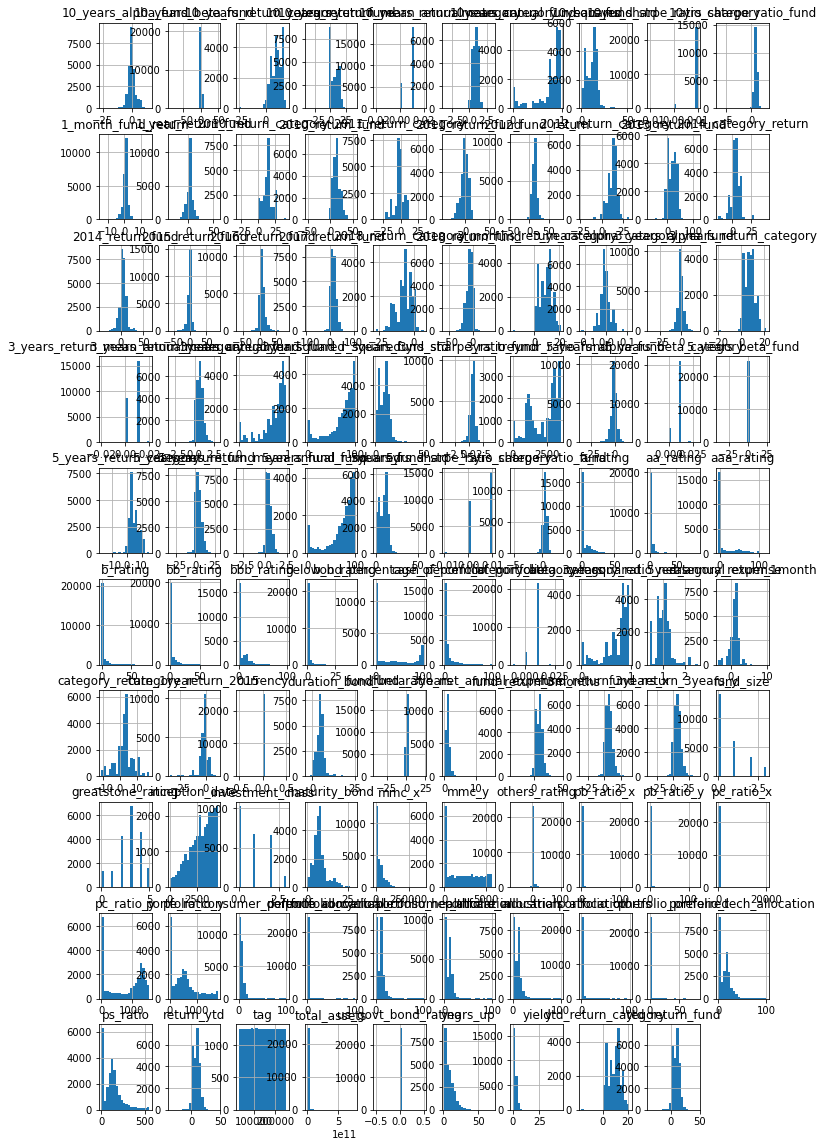

In [200]:
joint_9.hist(stacked=False, bins=20, figsize=(12, 20))

In [212]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

def remove_header(data, header_to_remove):
    if header_to_remove in data.columns:
        data = data.drop(columns=[header_to_remove])
    return data

#complete_predict_final_data_with_object = final_data.copy(deep=True)
tag_rating = pd.read_csv("tag_rating.csv")
joint_9 = join_8.merge(tag_rating[['greatstone_rating', 'fund_id']],  how='left', on='fund_id')

features_to_log_transform = ['fund_return_3years_x', 'fund_return_3years_y', '5_years_return_fund', '5yrs_sharpe_ratio_fund', 
                             '3yrs_sharpe_ratio_fund', '3_years_alpha_fund', '5_years_alpha_fund', '10_years_return_fund', 
                             '10yrs_sharpe_ratio_fund', '5_years_return_mean_annual_fund', '3_years_return_mean_annual_fund', 
                             '1_year_return_fund', '10_years_alpha_fund', '2018_return_fund', 
                             '10_years_return_mean_annual_fund', '2015_return_fund', '2014_return_fund', 
                             '1_month_fund_return', '10yrs_sharpe_ratio_category']

for feature in features_to_log_transform:
    if np.min(joint_9[feature])>0: # Look for integer data series
        joint_9[feature] = np.log1p(joint_9[feature])

complete_predict_final_data_with_object = joint_9.copy(deep=True)
joint_9.to_csv("complete_predict_final_data_with_object.csv")

complete_predict_final_data_without_object = joint_9.copy(deep=True)
complete_predict_final_data_without_object = cleanse_data_without_dropna(complete_predict_final_data_without_object, [])
complete_predict_final_data_without_object.to_csv("complete_predict_final_data_without_object.csv")


final_data = joint_9.copy(deep=True)
final_data = final_data.dropna(axis=0)
#print(")))))))))))))))))))))))))))))) is null ", final_data.isnull())

final_data.info()
print("===================================")
final_data = remove_header(final_data, 'tag')
final_data = remove_header(final_data, 'fund_id')
final_data = remove_header(final_data, 'fund_id_x')
final_data = remove_header(final_data, 'fund_id_y')
final_data = remove_header(final_data, 'fund_return_3years_x')
#final_data = remove_header(final_data, 'us_govt_bond_rating')
final_data = remove_header(final_data, 'inception_date')
final_data = remove_header(final_data, 'Unnamed')

final_data = cleanse_data(final_data, [])
final_data.to_csv("test_1.csv")
#final_data.to_csv("test_2.csv")
#pca = PCA(n_components=6)
#pca_fit = pca.fit(X_train)
#print(pca_fit.explained_variance_ratio_)
#X_train = pca_fit.transform(X_train)

#X_test = pca_fit.transform(X_test)
print("#####################################")

X_df = final_data.loc[:, final_data.columns != 'greatstone_rating']
y_df = final_data['greatstone_rating']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.30, random_state=0)

Columns size =  4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 24997
Columns: 110 entries, fund_id to greatstone_rating
dtypes: float64(95), int32(10), int64(1), object(4)
memory usage: 16.2+ MB
Columns size =  3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 24997
Columns: 106 entries, category to greatstone_rating
dtypes: float64(94), int32(12)
memory usage: 15.4 MB
cleanse_data  None
#####################################


In [210]:
final_data[['fund_return_3years_y', 'inception_date']].describe()

,fund_return_3years_y,inception_date
count,20000.000000,20000.000000
mean,6.982747,2851.984050
std,5.451173,1077.463821
min,-36.020000,0.000000
25%,2.800000,2107.000000
50%,6.820000,3019.000000
75%,10.200000,3770.250000
max,37.040000,4382.000000


In [166]:
X_df = final_data.loc[:, final_data.columns != 'greatstone_rating']
y_df = final_data['greatstone_rating']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.30, random_state=0)

In [152]:
complete_predict_final_data_without_object.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Columns: 103 entries, fund_id to greatstone_rating
dtypes: float64(89), int32(13), int64(1)
memory usage: 18.6 MB


# Classifier

In [202]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import r2_score

d = {'data type': ['train'], 'search' : ['random search'], 'name': ['0'], 'estimator': [0], 'r2 score': [0]}
model_performance = pd.DataFrame(data=d)

# User Random Search model
def random_search_classifier(model_type, model_name, distributions, model_performance):
    #pipe_svc = Pipeline([('scl', StandardScaler()),  ('pca', PCA(n_components=12)), (model_name, model_type)]) 
    pipe_svc = Pipeline([('scl', StandardScaler()), (model_name, model_type)]) 
    #pipe_svc = Pipeline([('scl', StandardScaler()), (model_name, model_type)]) 
    grid = RandomizedSearchCV(pipe_svc , distributions, cv = 5) 
    grid_fit = grid.fit(X_train, y_train) 
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    
    print("Test Recall score : {:.3f}". format(recall_score(y_test, y_test_pred, average="micro"))) 
    #print("Accuracy score : {:.3f}". format(accuracy_score(y_train, y_train_pred, average="micro")))  
    #print("Test Precision score : {:.3f}". format(precision_score(y_test, y_test_pred, average="micro")))
    print("Test Precision score : {:.3f}". format(precision_score(y_test, y_test_pred, average="micro")))
    
    print("Test Recall score : {:.3f}". format(recall_score(y_test, y_test_pred, average="macro"))) 
    #print("Accuracy score : {:.3f}". format(accuracy_score(y_train, y_train_pred, average="micro")))  
    #print("Test Precision score : {:.3f}". format(precision_score(y_test, y_test_pred, average="micro")))
    print("Test Precision score : {:.3f}". format(precision_score(y_test, y_test_pred, average="macro")))
    
    print("Train Recall score : {:.3f}". format(recall_score(y_train, y_train_pred, average="micro"))) 
    #print("Accuracy score : {:.3f}". format(accuracy_score(y_train, y_train_pred, average="micro")))  
    print("Train Precision score : {:.3f}". format(precision_score(y_train, y_train_pred, average="micro"))) 
 
    print(f"Best parameters are {grid.best_params_}")
    
    d = {'data type': ['train'], 'search' : ['random search'], 'name': [str(model_type)], 'estimator': [str(grid.best_params_)], 'r2 score': ["{:.3f}". format(r2_score(y_train, y_train_pred))]}
    pd_params = pd.DataFrame(data=d)

    model_performance = pd.concat([model_performance, pd_params])
    
    d = {'data type': ['test'], 'search' : ['random search'], 'name': [str(model_type)], 'estimator': [str(grid.best_params_)], 'r2 score': ["{:.3f}". format(r2_score(y_test, y_test_pred))]}
    pd_params = pd.DataFrame(data=d)
    model_performance = pd.concat([model_performance, pd_params]).reset_index(drop=True)
    
    return model_performance, grid

In [213]:
param_grid = {'rf__max_depth': [25], 'rf__bootstrap':[False], 'rf__ccp_alpha':[0], 'rf__verbose':[5], 'rf__min_samples_leaf':[2], 'rf__warm_start':[False], 'rf__class_weight':[None]} 
model_performance, rf_classifier_model = random_search_classifier(RandomForestClassifier(), 'rf', param_grid, model_performance)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 10

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Test Recall score : 0.776
Test Precision score : 0.776
Test Recall score : 0.771
Test Precision score : 0.814
Train Recall score : 1.000
Train Precision score : 1.000
Best parameters are {'rf__warm_start': False, 'rf__verbose': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 25, 'rf__class_weight': None, 'rf__ccp_alpha': 0, 'rf__bootstrap': False}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'rf__n_estimators': [100, 1000], 'rf__learning_rate':[0, 0.3], 'rf__max_depth':[5,10], 'rf__verbose':[5]} 
model_performance, gb_classifier_model = random_search_classifier(GradientBoostingClassifier(), 'rf', param_grid, model_performance)

In [46]:
from sklearn.neural_network import MLPClassifier

param_grid = {'rf__hidden_layer_sizes':[(500,)], 'rf__alpha':[1e-05], 'rf__max_iter':[500], 'rf__verbose':[True]} 
model_performance, gb_classifier_model = random_search_classifier(MLPClassifier(), 'rf', param_grid, model_performance)

Iteration 1, loss = 1.39914176
Iteration 2, loss = 1.20840042
Iteration 3, loss = 1.15477360
Iteration 4, loss = 1.12135945
Iteration 5, loss = 1.09633069
Iteration 6, loss = 1.08012890
Iteration 7, loss = 1.06297961
Iteration 8, loss = 1.04890814
Iteration 9, loss = 1.03946272
Iteration 10, loss = 1.02925226
Iteration 11, loss = 1.01545208
Iteration 12, loss = 1.00902305
Iteration 13, loss = 1.00098871
Iteration 14, loss = 0.99056550
Iteration 15, loss = 0.98335360
Iteration 16, loss = 0.97513798
Iteration 17, loss = 0.96833352
Iteration 18, loss = 0.96211555
Iteration 19, loss = 0.95414627
Iteration 20, loss = 0.94976924
Iteration 21, loss = 0.94167545
Iteration 22, loss = 0.93732138
Iteration 23, loss = 0.93012243
Iteration 24, loss = 0.92522184
Iteration 25, loss = 0.91920508
Iteration 26, loss = 0.91076706
Iteration 27, loss = 0.90874819
Iteration 28, loss = 0.90089249
Iteration 29, loss = 0.89551428
Iteration 30, loss = 0.89000081
Iteration 31, loss = 0.88619609
Iteration 32, los

Iteration 253, loss = 0.40353637
Iteration 254, loss = 0.40273229
Iteration 255, loss = 0.40314480
Iteration 256, loss = 0.39941381
Iteration 257, loss = 0.39728667
Iteration 258, loss = 0.39917060
Iteration 259, loss = 0.39827117
Iteration 260, loss = 0.39724361
Iteration 261, loss = 0.39483173
Iteration 262, loss = 0.39451033
Iteration 263, loss = 0.39214595
Iteration 264, loss = 0.39450196
Iteration 265, loss = 0.38940095
Iteration 266, loss = 0.39244382
Iteration 267, loss = 0.39082394
Iteration 268, loss = 0.38775301
Iteration 269, loss = 0.38852025
Iteration 270, loss = 0.38789046
Iteration 271, loss = 0.38676218
Iteration 272, loss = 0.38895532
Iteration 273, loss = 0.38939466
Iteration 274, loss = 0.38896673
Iteration 275, loss = 0.38577249
Iteration 276, loss = 0.38641209
Iteration 277, loss = 0.37880451
Iteration 278, loss = 0.37760232
Iteration 279, loss = 0.37823000
Iteration 280, loss = 0.38259175
Iteration 281, loss = 0.37427519
Iteration 282, loss = 0.37696429
Iteration 

Iteration 2, loss = 1.22502987
Iteration 3, loss = 1.16583934
Iteration 4, loss = 1.13027263
Iteration 5, loss = 1.10526312
Iteration 6, loss = 1.08536998
Iteration 7, loss = 1.07310919
Iteration 8, loss = 1.05942848
Iteration 9, loss = 1.04493480
Iteration 10, loss = 1.03705616
Iteration 11, loss = 1.02701459
Iteration 12, loss = 1.01456448
Iteration 13, loss = 1.00854957
Iteration 14, loss = 0.99934464
Iteration 15, loss = 0.99037607
Iteration 16, loss = 0.98476753
Iteration 17, loss = 0.97735910
Iteration 18, loss = 0.97184137
Iteration 19, loss = 0.96280791
Iteration 20, loss = 0.95943612
Iteration 21, loss = 0.95083719
Iteration 22, loss = 0.94526445
Iteration 23, loss = 0.93942213
Iteration 24, loss = 0.93160463
Iteration 25, loss = 0.92788872
Iteration 26, loss = 0.92159729
Iteration 27, loss = 0.91616211
Iteration 28, loss = 0.91268683
Iteration 29, loss = 0.90900238
Iteration 30, loss = 0.90296091
Iteration 31, loss = 0.89791915
Iteration 32, loss = 0.89597779
Iteration 33, lo

Iteration 254, loss = 0.41716073
Iteration 255, loss = 0.41512850
Iteration 256, loss = 0.41435706
Iteration 257, loss = 0.41597311
Iteration 258, loss = 0.41734759
Iteration 259, loss = 0.41175916
Iteration 260, loss = 0.41397436
Iteration 261, loss = 0.41065862
Iteration 262, loss = 0.40977218
Iteration 263, loss = 0.40740479
Iteration 264, loss = 0.41525419
Iteration 265, loss = 0.40944572
Iteration 266, loss = 0.40389542
Iteration 267, loss = 0.40540839
Iteration 268, loss = 0.40088332
Iteration 269, loss = 0.41433837
Iteration 270, loss = 0.40249877
Iteration 271, loss = 0.39908775
Iteration 272, loss = 0.40301907
Iteration 273, loss = 0.39717617
Iteration 274, loss = 0.40002229
Iteration 275, loss = 0.39795062
Iteration 276, loss = 0.39501242
Iteration 277, loss = 0.39294986
Iteration 278, loss = 0.39467600
Iteration 279, loss = 0.39378336
Iteration 280, loss = 0.39490290
Iteration 281, loss = 0.39394824
Iteration 282, loss = 0.39745058
Iteration 283, loss = 0.39176393
Iteration 

Iteration 3, loss = 1.16314016
Iteration 4, loss = 1.12808108
Iteration 5, loss = 1.10174517
Iteration 6, loss = 1.08591093
Iteration 7, loss = 1.07043976
Iteration 8, loss = 1.05590104
Iteration 9, loss = 1.04422034
Iteration 10, loss = 1.03356771
Iteration 11, loss = 1.02353499
Iteration 12, loss = 1.01518995
Iteration 13, loss = 1.00778392
Iteration 14, loss = 0.99955264
Iteration 15, loss = 0.99221104
Iteration 16, loss = 0.98568103
Iteration 17, loss = 0.97778909
Iteration 18, loss = 0.97121777
Iteration 19, loss = 0.96443570
Iteration 20, loss = 0.95728249
Iteration 21, loss = 0.95167950
Iteration 22, loss = 0.94781227
Iteration 23, loss = 0.93985842
Iteration 24, loss = 0.93850296
Iteration 25, loss = 0.93218788
Iteration 26, loss = 0.92349793
Iteration 27, loss = 0.92073716
Iteration 28, loss = 0.91246371
Iteration 29, loss = 0.90680651
Iteration 30, loss = 0.90422931
Iteration 31, loss = 0.89964327
Iteration 32, loss = 0.89158059
Iteration 33, loss = 0.88881453
Iteration 34, l

Iteration 255, loss = 0.41341674
Iteration 256, loss = 0.42453007
Iteration 257, loss = 0.41502079
Iteration 258, loss = 0.40970429
Iteration 259, loss = 0.40876653
Iteration 260, loss = 0.40945354
Iteration 261, loss = 0.40774463
Iteration 262, loss = 0.40640847
Iteration 263, loss = 0.40393556
Iteration 264, loss = 0.40484029
Iteration 265, loss = 0.40590473
Iteration 266, loss = 0.40521068
Iteration 267, loss = 0.39926519
Iteration 268, loss = 0.40049382
Iteration 269, loss = 0.40297168
Iteration 270, loss = 0.39429389
Iteration 271, loss = 0.40036591
Iteration 272, loss = 0.40096924
Iteration 273, loss = 0.40202694
Iteration 274, loss = 0.39565238
Iteration 275, loss = 0.39516595
Iteration 276, loss = 0.39430726
Iteration 277, loss = 0.39309409
Iteration 278, loss = 0.39384643
Iteration 279, loss = 0.39595405
Iteration 280, loss = 0.39413553
Iteration 281, loss = 0.39297300
Iteration 282, loss = 0.38767509
Iteration 283, loss = 0.38489033
Iteration 284, loss = 0.38509020
Iteration 

Iteration 4, loss = 1.12532533
Iteration 5, loss = 1.10089139
Iteration 6, loss = 1.08196454
Iteration 7, loss = 1.06727784
Iteration 8, loss = 1.05246939
Iteration 9, loss = 1.04040315
Iteration 10, loss = 1.02794133
Iteration 11, loss = 1.01953280
Iteration 12, loss = 1.01195179
Iteration 13, loss = 1.00541191
Iteration 14, loss = 0.99461569
Iteration 15, loss = 0.98954637
Iteration 16, loss = 0.98035429
Iteration 17, loss = 0.97349593
Iteration 18, loss = 0.96826898
Iteration 19, loss = 0.95916626
Iteration 20, loss = 0.95325252
Iteration 21, loss = 0.95009978
Iteration 22, loss = 0.93990002
Iteration 23, loss = 0.93407552
Iteration 24, loss = 0.92860181
Iteration 25, loss = 0.92576217
Iteration 26, loss = 0.92012549
Iteration 27, loss = 0.91466739
Iteration 28, loss = 0.90930847
Iteration 29, loss = 0.90247736
Iteration 30, loss = 0.89714023
Iteration 31, loss = 0.89588974
Iteration 32, loss = 0.88962117
Iteration 33, loss = 0.88373310
Iteration 34, loss = 0.87969496
Iteration 35, 

Iteration 256, loss = 0.41019395
Iteration 257, loss = 0.40660884
Iteration 258, loss = 0.40854469
Iteration 259, loss = 0.40586547
Iteration 260, loss = 0.40542866
Iteration 261, loss = 0.40640054
Iteration 262, loss = 0.40270790
Iteration 263, loss = 0.40414718
Iteration 264, loss = 0.40567407
Iteration 265, loss = 0.40468954
Iteration 266, loss = 0.39707560
Iteration 267, loss = 0.39609301
Iteration 268, loss = 0.39766050
Iteration 269, loss = 0.39680846
Iteration 270, loss = 0.39530599
Iteration 271, loss = 0.39387706
Iteration 272, loss = 0.39352859
Iteration 273, loss = 0.39065103
Iteration 274, loss = 0.39103799
Iteration 275, loss = 0.39614873
Iteration 276, loss = 0.39282904
Iteration 277, loss = 0.38877485
Iteration 278, loss = 0.39107591
Iteration 279, loss = 0.38771311
Iteration 280, loss = 0.38556790
Iteration 281, loss = 0.39033395
Iteration 282, loss = 0.38205109
Iteration 283, loss = 0.38275463
Iteration 284, loss = 0.38020707
Iteration 285, loss = 0.37973247
Iteration 

Iteration 10, loss = 1.01871142
Iteration 11, loss = 1.00805745
Iteration 12, loss = 0.99972794
Iteration 13, loss = 0.98972243
Iteration 14, loss = 0.98309346
Iteration 15, loss = 0.97493729
Iteration 16, loss = 0.97072200
Iteration 17, loss = 0.95782433
Iteration 18, loss = 0.95446562
Iteration 19, loss = 0.94642730
Iteration 20, loss = 0.94008750
Iteration 21, loss = 0.93634230
Iteration 22, loss = 0.92862030
Iteration 23, loss = 0.92770063
Iteration 24, loss = 0.91702865
Iteration 25, loss = 0.91608984
Iteration 26, loss = 0.90618865
Iteration 27, loss = 0.90053033
Iteration 28, loss = 0.89851384
Iteration 29, loss = 0.89173202
Iteration 30, loss = 0.88665493
Iteration 31, loss = 0.88171067
Iteration 32, loss = 0.87422109
Iteration 33, loss = 0.86949486
Iteration 34, loss = 0.86368555
Iteration 35, loss = 0.86148272
Iteration 36, loss = 0.85671900
Iteration 37, loss = 0.85206596
Iteration 38, loss = 0.84908362
Iteration 39, loss = 0.84657733
Iteration 40, loss = 0.83878147
Iteratio

Iteration 261, loss = 0.41666729
Iteration 262, loss = 0.41921026
Iteration 263, loss = 0.41685564
Iteration 264, loss = 0.41307232
Iteration 265, loss = 0.42328264
Iteration 266, loss = 0.41341520
Iteration 267, loss = 0.41420192
Iteration 268, loss = 0.41349294
Iteration 269, loss = 0.41375487
Iteration 270, loss = 0.41262502
Iteration 271, loss = 0.41075210
Iteration 272, loss = 0.40842057
Iteration 273, loss = 0.40607051
Iteration 274, loss = 0.41108404
Iteration 275, loss = 0.40609199
Iteration 276, loss = 0.40420319
Iteration 277, loss = 0.40624369
Iteration 278, loss = 0.40171073
Iteration 279, loss = 0.40129058
Iteration 280, loss = 0.40461131
Iteration 281, loss = 0.39789310
Iteration 282, loss = 0.40080829
Iteration 283, loss = 0.40238607
Iteration 284, loss = 0.40104676
Iteration 285, loss = 0.40058851
Iteration 286, loss = 0.39793101
Iteration 287, loss = 0.39704558
Iteration 288, loss = 0.39347128
Iteration 289, loss = 0.39552545
Iteration 290, loss = 0.39006402
Iteration 

# Predict Result

In [53]:
complete_predict_final_data_with_object.shape

(25000, 30)

In [54]:
complete_predict_final_data_without_object.shape

(25000, 30)

In [55]:
X_df.shape

(20000, 24)

In [ ]:
X_train.columns

In [ ]:
complete_predict_final_data_without_object.info()

In [171]:
result_pd = pd.DataFrame()
result_pd['greatstone_rating'] = rf_classifier_model.predict(complete_predict_final_data_without_object[X_train.columns])
result_pd['fund_id'] = complete_predict_final_data_with_object['fund_id']
result_pd['fund_id'] = result_pd['fund_id'].astype(object)
result_pd.to_csv("predicted.csv")

sample_submission = pd.read_csv('sample_submission.csv')

result_1 = sample_submission.drop(columns=['greatstone_rating']).merge(result_pd, how='left', on='fund_id')
result_1.to_csv("to_submit.csv")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished


# Results

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.info()

sample_submission.head()

In [ ]:
other_specs = pd.read_csv('other_specs.csv')
other_specs_submission  = other_specs[['tag' , 'greatstone_rating']]

print("other specs------------------")
print(other_specs_submission.head())

######################################
fund_ratios = pd.read_csv('fund_ratios.csv')
fund_ratios_partial = fund_ratios[['tag', 'fund_id']]

final_1 = fund_ratios_partial.merge(other_specs_submission, how='inner', on='tag')
print("fund_ratios------------------")
print(final_1.head())

######################################
final_2 = sample_submission.merge(final_1, how='inner', on='fund_id')
print("sample_submission------------")
print(final_2.head())

final_2.to_csv("submit.csv")